In [1]:
import os
import numpy as np
import pandas as pd
import itertools
from math import log10, floor
import matplotlib.pyplot as plt
from matplotlib_venn import venn3
import seaborn as sns
import lq_biopsy as lq

Define Variables

In [2]:
path = os.path.join('outputs', 'preprocessing')
subjects = [110, 141, 142, 150, 171]

genes = ['CASP8',
 'CDKN2A',
 'FAT1',
 'FBXW7',
 'KMT2D',
 'NOTCH1',
 'NSD1',
 'PIK3CA',
 'TP53']
xvals = [0, 0.5, 3, 12]
timepoints = {'A' : 'baseline', 'B' : '6W', 'C' : '3M', 'D' : '12M'}

Load Data

In [3]:
ctDNA_dict = {subject : pd.read_csv(f'outputs/recurrence_profiles/{subject}_filtered.tsv', sep = '\t') for subject in subjects}

Save recurrence profile data

In [4]:
data = ctDNA_dict
profiles = {subject : {} for subject in subjects}
for subject in subjects:
    profile = np.empty([len(data[subject].columns[10:]), len(data[subject])])
    profile[:] = np.NaN
    idx = 0
    cosmic_info = data[subject]['INFO']
    cosmic_info = [np.array(l.split(';'))[np.char.find(l.split(';'), 'cosmic') != -1] for l in cosmic_info]
    id_true = np.where([np.any((np.char.find(l, 'upper_aerodigestive_tract') != -1) == True) for l in cosmic_info])[0]
    profiles[subject]['annotated'] = np.array([False]*len(data[subject]))
    profiles[subject]['annotated'][id_true] = True

    dfg = []

    inf = np.array(data[subject]['INFO'])
    for i in inf:
        s = i.split(';')
        idc = list(np.where(np.char.find(s, 'upper_aerodigestive_tract') != -1)[0])
        if len(idc) == 0:
            dfg.append('NaN')
        else:
            anno = [s[i] for i in idc]
            id = []
            for ln in anno:
                s2 = ln.split('\\')
                ids = list(np.where(np.char.find(s2, 'x3dCOS') != -1)[0])
                id.append(*[s2[i] for i in ids])
            id = list(set(id))
            id = [i.strip('x3d') for i in id]
            dfg.append(id)
    
    profiles[subject]['ids'] = dfg
    
    tempprof = {}
    for tp in [f'{subject}_Core', f'{subject}_Margin', f'{subject}A', f'{subject}B', f'{subject}C', f'{subject}D']:
        if tp in data[subject].columns:
            x = data[subject][tp]
            y = [np.array(l.split(':')).T[6] for l in x]
            y = np.array([i.strip('%') for i in y])
            tempprof[tp] = y
        idx += 1

    profiles[subject]['profile'] = profile.T

    df = pd.DataFrame({'CHR' : data[subject]['CHROM'], 
                                                'POS' : data[subject]['POS'], 
                                                'GENE' : data[subject]['GENE'],
                                                'ID' : profiles[subject]['ids'], 
                                                'REF' : data[subject]['REF'],
                                                'ALT' : data[subject]['ALT']})
    
    df = df.join(pd.DataFrame(tempprof))
    df.to_csv(f'outputs/recurrence_profiles/{subject}_profile.tsv', sep='\t', index = False)

Remove uninformant variants

In [5]:
for subject in subjects:
    bools = {j : np.array([bool(float((i.strip('%')))) for i in np.stack([v.split(':') for v in ctDNA_dict[subject][j]]).T[6]]) for j in ctDNA_dict[subject].columns[12:]}
    interest = np.stack([list(bools.values())[0], list(bools.values())[-1]]).T
    keep = np.array([i.any() for i in interest])
    print(f'Dropping {len(ctDNA_dict[subject])- len([i for i in keep if i])} of {len(ctDNA_dict[subject])} variants')
    ctDNA_dict[subject] = ctDNA_dict[subject][keep].reset_index(drop=True)

    cov = pd.DataFrame(lq.get_coverage(ctDNA_dict[subject]))
    cov.to_csv(f'outputs/recurrence_profiles/{subject}_coverage.tsv', sep = '\t', index = False)


Dropping 5077 of 14587 variants
Dropping 7097 of 14986 variants
Dropping 6845 of 17090 variants
Dropping 5252 of 15312 variants
Dropping 6242 of 16838 variants


In [6]:
BAF_dict = {subject : {gene : {} for gene in genes} for subject in subjects}
for subject in subjects:
    for gene in genes:
        for tp in ctDNA_dict[subject][np.array(ctDNA_dict[subject]['GENE']) == gene].columns[12:]:
            freq_str = np.stack([v.split(':') for v in ctDNA_dict[subject][np.array(ctDNA_dict[subject]['GENE']) == gene][tp]]).T[6]
            BAF_dict[subject][gene][timepoints[tp[-1]]] = (np.array([f.strip('%') for f in freq_str]).astype(float) / 100)

    BAF_dict[subject]['all'] = {tp : list(itertools.chain(*[BAF_dict[subject][gene][tp] for gene in BAF_dict[subject]])) for tp in BAF_dict[subject]['TP53']}
        

Get change in variant composition over time

In [7]:
het_rates = {tp : {subject : {gene : {} for gene in BAF_dict[subject]} for subject in subjects} for tp in ['baseline', 'final_point', 'common']}
for subject in subjects:

    for gene in BAF_dict[subject]:
        b = np.array(BAF_dict[subject][gene]['baseline']).astype(bool)  
        f = np.array(BAF_dict[subject][gene][list(BAF_dict[subject][gene].keys())[-1]]).astype(bool)
        temp = [i.all() for i in np.stack([b,f]).T]
        both = np.where(temp)[0]
        b[both] = False
        f[both] = False

        het_rates['baseline'][subject][gene] = len(np.where(b)[0]) / len(b)
        het_rates['final_point'][subject][gene] = len(np.where(f)[0]) / len(f)
        het_rates['common'][subject][gene] = len(both) / len(f)

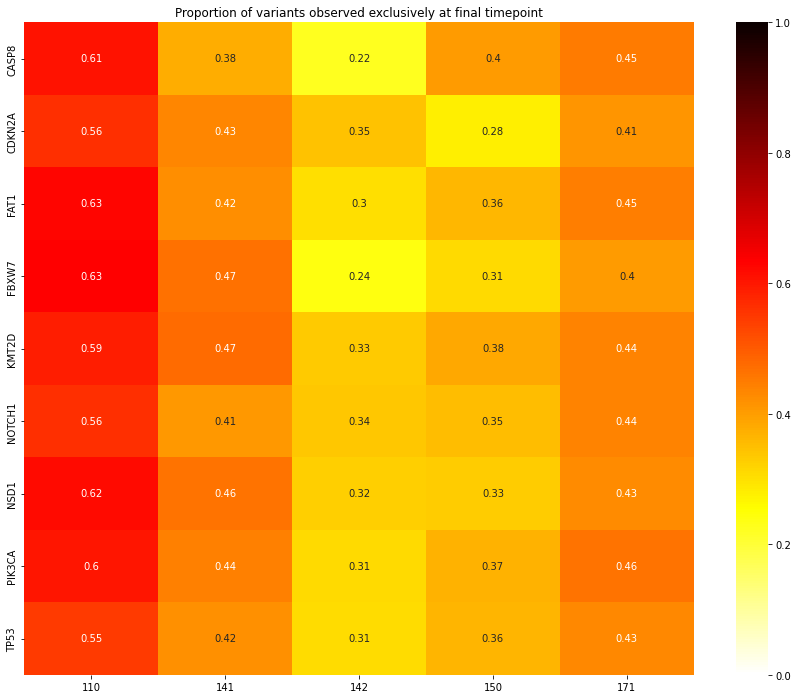

In [8]:
plt.figure(figsize=(15,12))
sns.heatmap(pd.DataFrame(het_rates['final_point']).iloc[:-1], annot = True, cmap = 'hot_r', vmin=0, vmax=1)
plt.title('Proportion of variants observed exclusively at final timepoint')
plt.savefig('outputs/recurrence_profiles/tp_het.svg', format='svg')
plt.savefig('outputs/recurrence_profiles/tp_het')

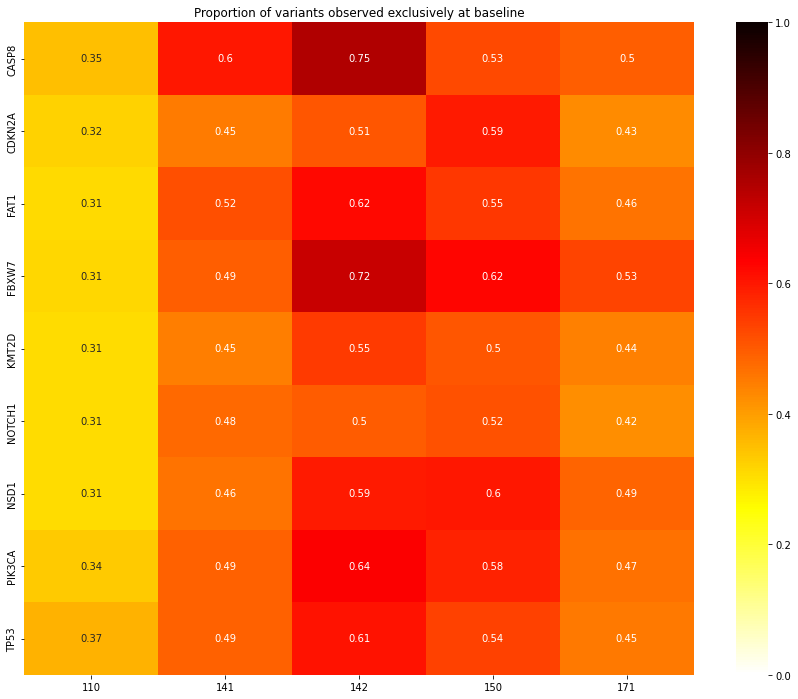

In [9]:
plt.figure(figsize=(15,12))
sns.heatmap(pd.DataFrame(het_rates['baseline']).iloc[:-1], annot = True, cmap = 'hot_r', vmin=0, vmax=1)
plt.title('Proportion of variants observed exclusively at baseline')
plt.savefig('outputs/recurrence_profiles/bl_het.svg', format='svg')
plt.savefig('outputs/recurrence_profiles/bl_het')

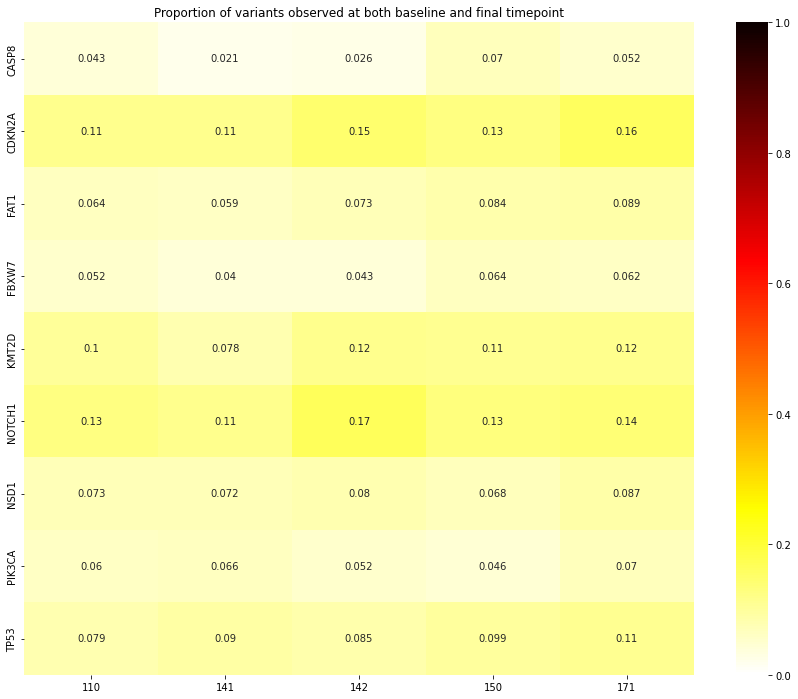

In [10]:
plt.figure(figsize=(15,12))
sns.heatmap(pd.DataFrame(het_rates['common']).iloc[:-1], annot = True, cmap = 'hot_r', vmin=0, vmax=1)
plt.title('Proportion of variants observed at both baseline and final timepoint')
plt.savefig('outputs/recurrence_profiles/both_het.svg', format='svg')
plt.savefig('outputs/recurrence_profiles/both_het')

Get change in mutational burden of baseline variants

In [11]:
bl_change = {subject : {gene : {} for gene in genes} for subject in subjects}
for subject in subjects:
    for gene in genes:
        observed_at_baseline = list(BAF_dict[subject][gene]['baseline'].astype(bool))
        for tp in BAF_dict[subject][gene]:
            bl_change[subject][gene][tp] = BAF_dict[subject][gene][tp][observed_at_baseline]

    bl_change[subject]['all'] = {tp : list(itertools.chain(*[bl_change[subject][gene][tp] for gene in bl_change[subject]])) for tp in bl_change[subject]['TP53']}


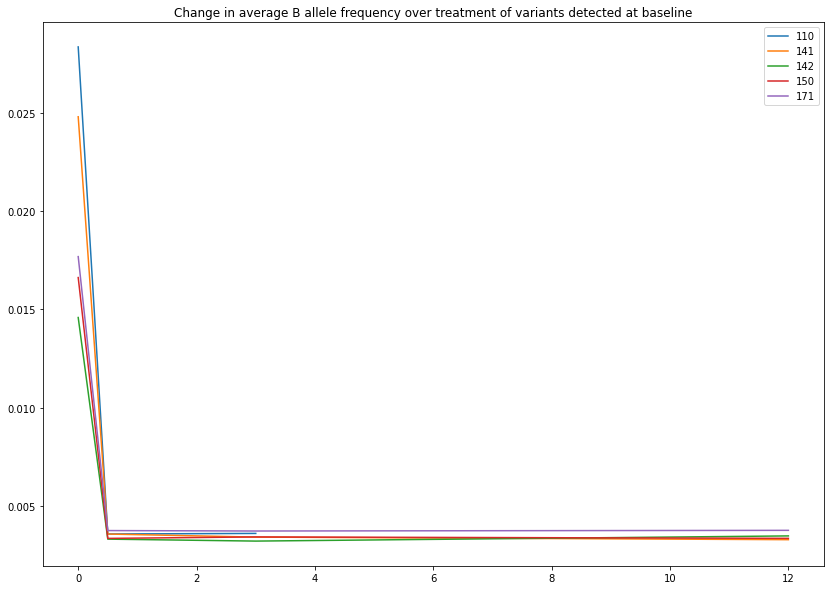

In [12]:
plt.figure(figsize=(14,10))
for subject in subjects:
    if len(BAF_dict[subject]['all']) > 1:
        x = xvals[:len(BAF_dict[subject]['all'])]
        plt.plot(x, [np.mean(bl_change[subject]['all'][i]) for i in bl_change[subject]['all']], label = subject)
plt.legend()
plt.title('Change in average B allele frequency over treatment of variants detected at baseline')
plt.savefig(f'outputs/recurrence_profiles/bl_load')
plt.savefig(f'outputs/recurrence_profiles/bl_load.svg', format='svg')

Cosmic Specific Variants

In [13]:
ctDNA_dict = {subject : pd.read_csv(f'outputs/recurrence_profiles/{subject}_filtered_HNSCC.tsv', sep = '\t') for subject in subjects}

In [14]:
data = ctDNA_dict
profiles = {subject : {} for subject in subjects}
for subject in subjects:
    profile = np.empty([len(data[subject].columns[10:]), len(data[subject])])
    profile[:] = np.NaN
    idx = 0
    cosmic_info = data[subject]['INFO']
    cosmic_info = [np.array(l.split(';'))[np.char.find(l.split(';'), 'cosmic') != -1] for l in cosmic_info]
    id_true = np.where([np.any((np.char.find(l, 'upper_aerodigestive_tract') != -1) == True) for l in cosmic_info])[0]
    profiles[subject]['annotated'] = np.array([False]*len(data[subject]))
    profiles[subject]['annotated'][id_true] = True

    dfg = []

    inf = np.array(data[subject]['INFO'])
    for i in inf:
        s = i.split(';')
        idc = list(np.where(np.char.find(s, 'upper_aerodigestive_tract') != -1)[0])
        if len(idc) == 0:
            dfg.append('NaN')
        else:
            anno = [s[i] for i in idc]
            id = []
            for ln in anno:
                s2 = ln.split('\\')
                ids = list(np.where(np.char.find(s2, 'x3dCOS') != -1)[0])
                id.append(*[s2[i] for i in ids])
            id = list(set(id))
            id = [i.strip('x3d') for i in id]
            dfg.append(id)
    
    profiles[subject]['ids'] = dfg
    
    tempprof = {}
    for tp in [f'{subject}_Core', f'{subject}_Margin', f'{subject}A', f'{subject}B', f'{subject}C', f'{subject}D']:
        if tp in data[subject].columns:
            x = data[subject][tp]
            y = [np.array(l.split(':')).T[6] for l in x]
            y = np.array([i.strip('%') for i in y])
            tempprof[tp] = y
        idx += 1

    profiles[subject]['profile'] = profile.T

    df = pd.DataFrame({'CHR' : data[subject]['CHROM'], 
                                                'POS' : data[subject]['POS'], 
                                                'GENE' : data[subject]['GENE'],
                                                'ID' : profiles[subject]['ids'], 
                                                'REF' : data[subject]['REF'],
                                                'ALT' : data[subject]['ALT']})
    
    df = df.join(pd.DataFrame(tempprof))
    df.to_csv(f'outputs/recurrence_profiles/{subject}_profile_HNSCC.tsv', sep='\t', index = False)

In [15]:
BAF_dict = {subject : {gene : {} for gene in genes} for subject in subjects}
for subject in subjects:
    for gene in genes:
        for no, var in ctDNA_dict[subject][np.array(ctDNA_dict[subject]['GENE']) == gene].iterrows():
            id = max(var['INFO'].split(';'), key=len).split('x3d')[1].split('\\')[0]
            BAF_dict[subject][gene][id] = {timepoints[tp[-1]] : (float(var[tp].split(':')[6].strip('%')) / 100) for tp in ctDNA_dict[subject].columns[12:]}

    BAF_dict[subject]['all'] = {}
    for no, var in ctDNA_dict[subject].iterrows():
        id = max(var['INFO'].split(';'), key=len).split('x3d')[1].split('\\')[0]
        BAF_dict[subject]['all'][id] = {timepoints[tp[-1]] : (float(var[tp].split(':')[6].strip('%')) / 100) for tp in ctDNA_dict[subject].columns[12:]}

In [16]:
for subject in subjects:
    bools = {j : np.array([bool(float((i.strip('%')))) for i in np.stack([v.split(':') for v in ctDNA_dict[subject][j]]).T[6]]) for j in ctDNA_dict[subject].columns[12:]}
    interest = np.stack([list(bools.values())[0], list(bools.values())[-1]]).T
    keep = np.array([i.any() for i in interest])
    print(f'Dropping {len(ctDNA_dict[subject])- len([i for i in keep if i])} of {len(ctDNA_dict[subject])} variants')
    ctDNA_dict[subject] = ctDNA_dict[subject][keep].reset_index(drop=True)

    cov = pd.DataFrame(lq.get_coverage(ctDNA_dict[subject]))
    cov.to_csv(f'outputs/recurrence_profiles/{subject}_coverage_HNSCC.tsv', sep = '\t', index = False)

Dropping 101 of 310 variants
Dropping 143 of 308 variants
Dropping 133 of 323 variants
Dropping 113 of 316 variants
Dropping 117 of 341 variants


Get genomic profiles of all COSMIC annotated variants

In [17]:
BAF_dict = {subject : {gene : {} for gene in genes} for subject in subjects}
for subject in subjects:
    for gene in genes:
        for no, var in ctDNA_dict[subject][np.array(ctDNA_dict[subject]['GENE']) == gene].iterrows():
            id = max(var['INFO'].split(';'), key=len).split('x3d')[1].split('\\')[0]
            BAF_dict[subject][gene][id] = {timepoints[tp[-1]] : (float(var[tp].split(':')[6].strip('%')) / 100) for tp in ctDNA_dict[subject].columns[12:]}
        if len(list(BAF_dict[subject][gene].keys())) == 0:
            BAF_dict[subject][gene]['placeholder'] = {timepoints[tp[-1]] : None for tp in ctDNA_dict[subject].columns[12:]}

    BAF_dict[subject]['all'] = {}
    for no, var in ctDNA_dict[subject].iterrows():
        id = max(var['INFO'].split(';'), key=len).split('x3d')[1].split('\\')[0]
        BAF_dict[subject]['all'][id] = {timepoints[tp[-1]] : (float(var[tp].split(':')[6].strip('%')) / 100) for tp in ctDNA_dict[subject].columns[12:]}

In [18]:
recc = {subject : {reg : {} for reg in BAF_dict[subject]} for subject in subjects}
for subject in BAF_dict:
    for reg in BAF_dict[subject]:
        recc[subject][reg] = np.stack([list(i.values()) for i in list(BAF_dict[subject][reg].values())])


In [19]:
recc2 = {subject : {reg : {tp : {} for tp in BAF_dict[subject][reg][list(BAF_dict[subject][reg].keys())[0]]} for reg in BAF_dict[subject]} for subject in subjects}
for subject in subjects:
    for reg in BAF_dict[subject]:
        for tp in recc2[subject][reg]:
            recc2[subject][reg][tp] = recc[subject][reg].T[list(BAF_dict[subject][reg][list(BAF_dict[subject][reg].keys())[0]].keys()).index(tp)]

In [20]:
bl_change = {subject : {gene : {} for gene in genes} for subject in subjects}
for subject in subjects:
    for gene in genes:
        observed_at_baseline = list(recc2[subject][gene]['baseline'].astype(bool))
        for tp in recc2[subject][gene]:
            bl_change[subject][gene][tp] = recc2[subject][gene][tp][observed_at_baseline]

    bl_change[subject]['all'] = {tp : list(itertools.chain(*[bl_change[subject][gene][tp] for gene in bl_change[subject]])) for tp in bl_change[subject]['TP53']}

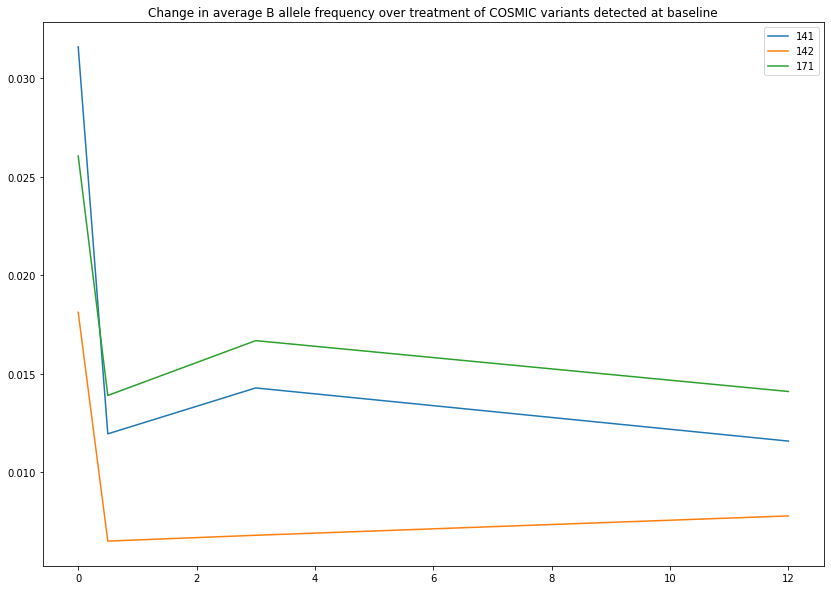

In [21]:
plt.figure(figsize=(14,10))
for subject in subjects:
    if len(recc2[subject]['all']) > 1 and subject in [141, 142, 171]:
        x = xvals[:len(recc2[subject]['all'])]
        plt.plot(x, [np.mean(bl_change[subject]['all'][i]) for i in bl_change[subject]['all'] if i], label = subject)
plt.legend()
plt.title('Change in average B allele frequency over treatment of COSMIC variants detected at baseline')
plt.savefig(f'outputs/recurrence_profiles/bl_load_HNSCC')
plt.savefig(f'outputs/recurrence_profiles/bl_load_HNSCC.svg', format='svg')

In [22]:
BAF_dict = {subject : {gene : {} for gene in genes} for subject in subjects}
for subject in subjects:
    for gene in genes:
        for no, var in ctDNA_dict[subject][np.array(ctDNA_dict[subject]['GENE']) == gene].iterrows():

            x = np.where(np.char.find(var['INFO'].split(';'), 'upper_aerodigestive_tract') != -1)[0][0]
            id = var['INFO'].split(';')[x].split('x3d')[1].split('\\')[0]
            BAF_dict[subject][gene][id] = {timepoints[tp[-1]] : (float(var[tp].split(':')[6].strip('%')) / 100) for tp in ctDNA_dict[subject].columns[12:]}

    BAF_dict[subject]['all'] = {}
    for no, var in ctDNA_dict[subject].iterrows():
        x = np.where(np.char.find(var['INFO'].split(';'), 'upper_aerodigestive_tract') != -1)[0][0]
        id = var['INFO'].split(';')[x].split('x3d')[1].split('\\')[0]
        BAF_dict[subject]['all'][id] = {timepoints[tp[-1]] : (float(var[tp].split(':')[6].strip('%')) / 100) for tp in ctDNA_dict[subject].columns[12:]}

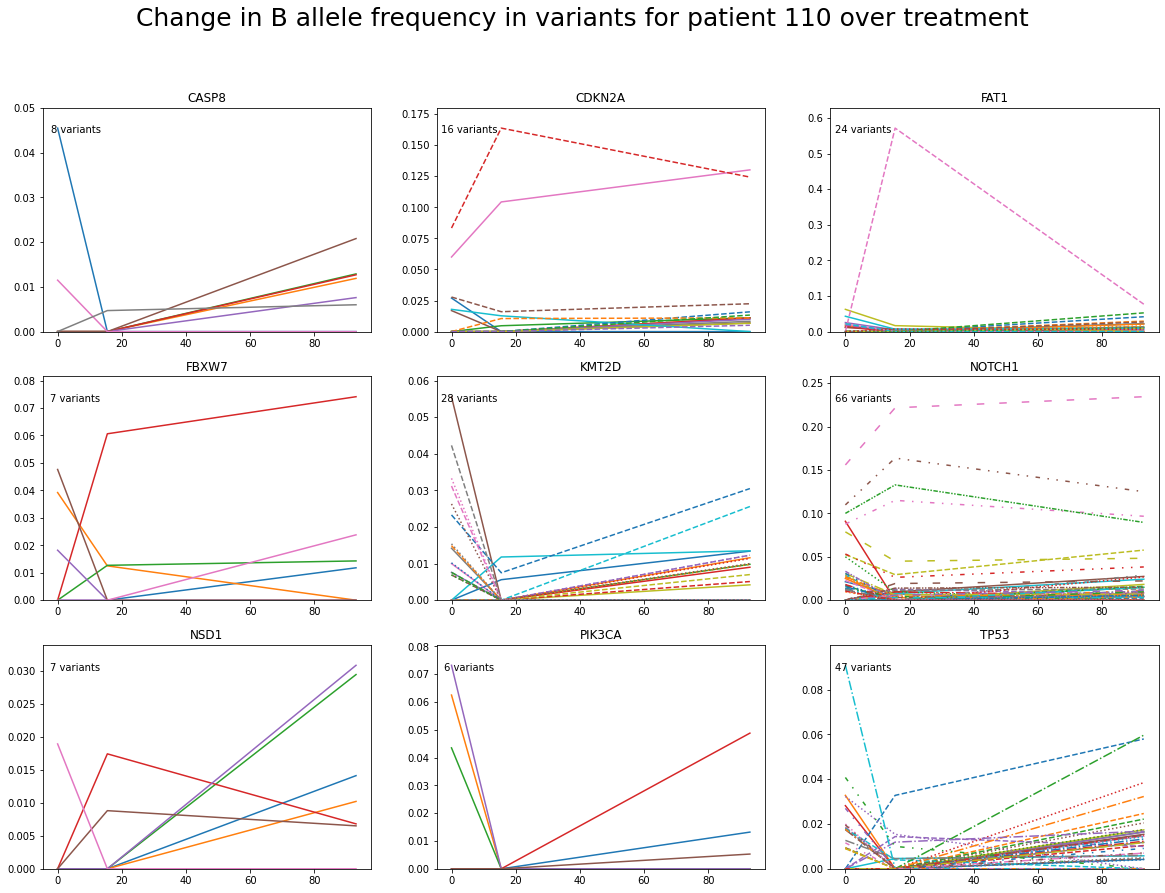

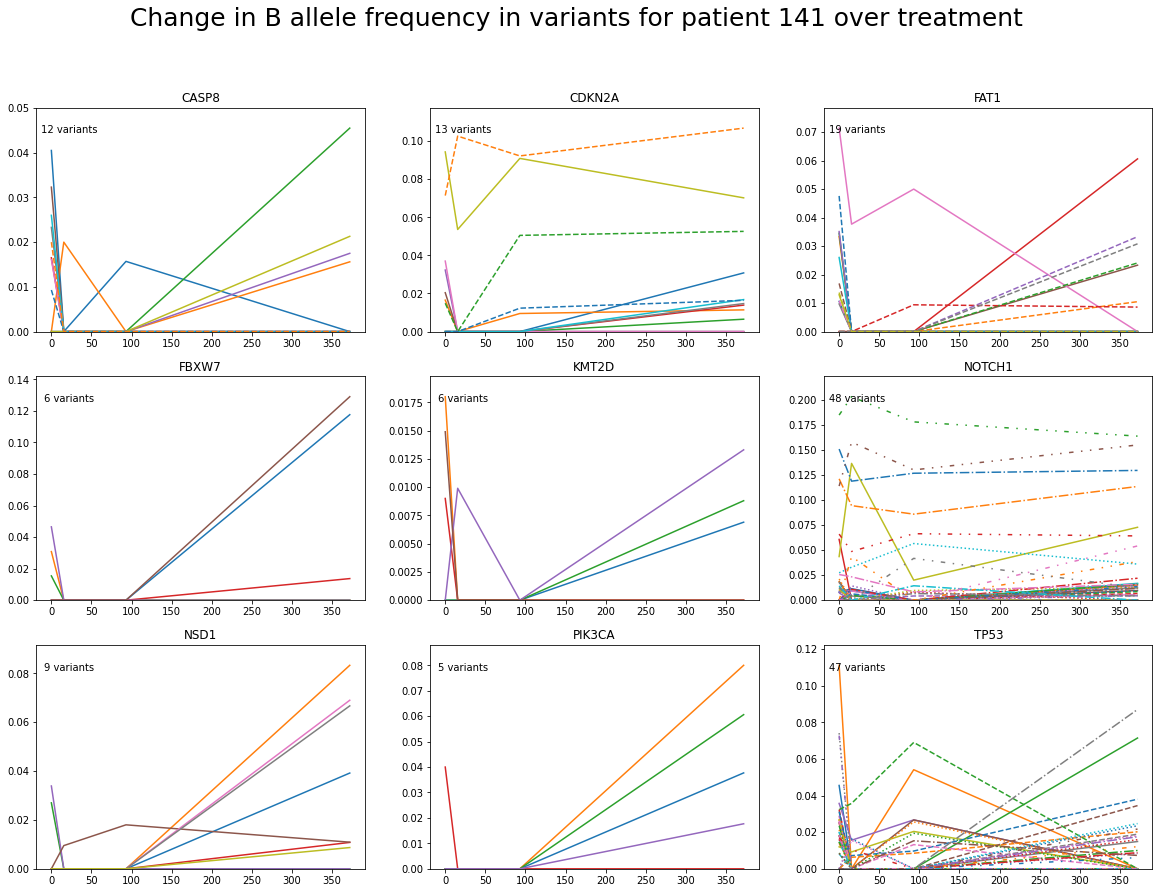

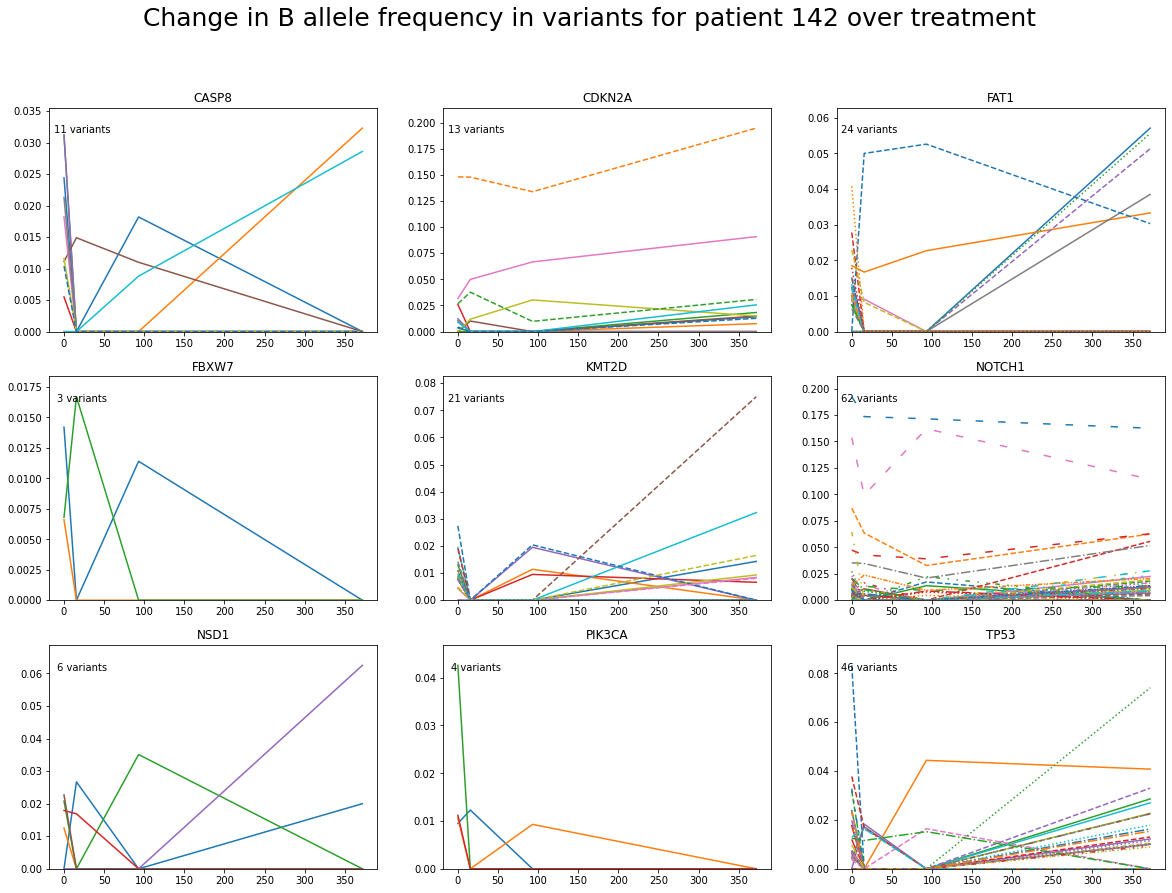

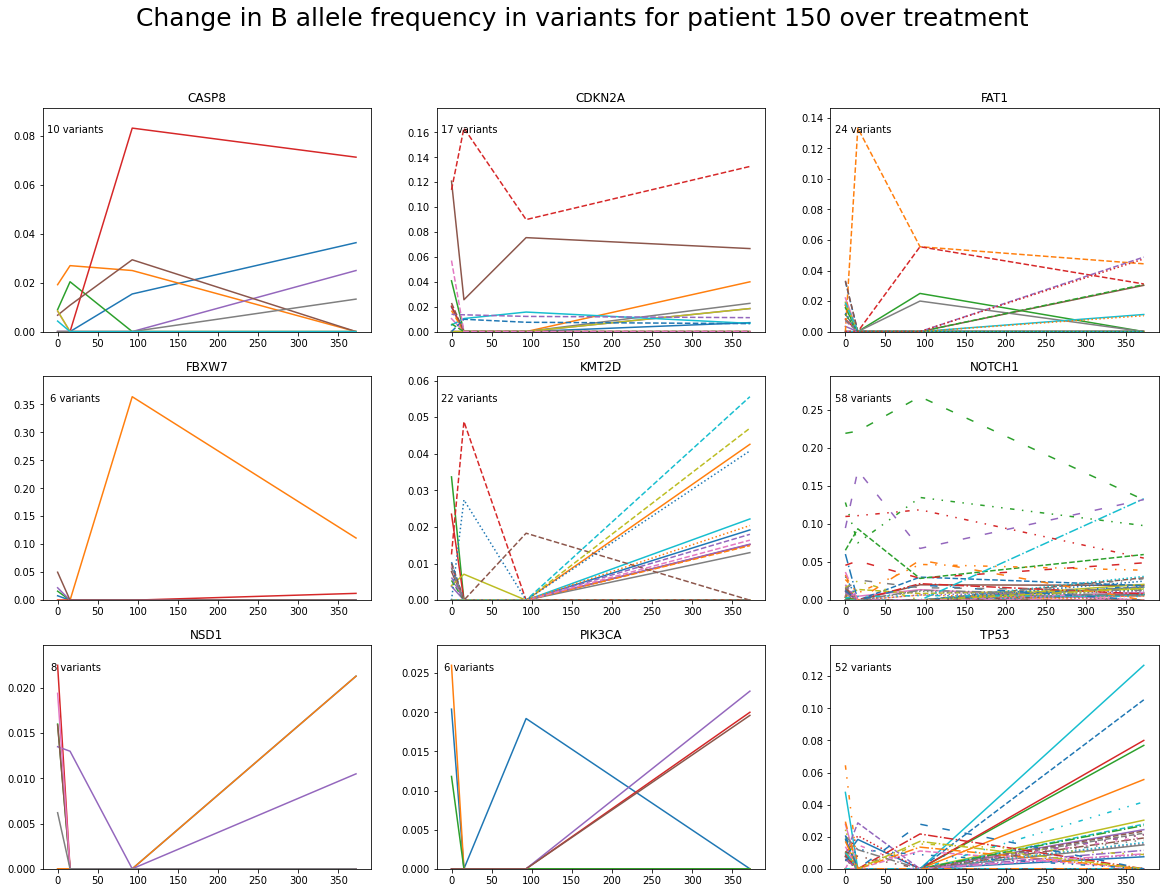

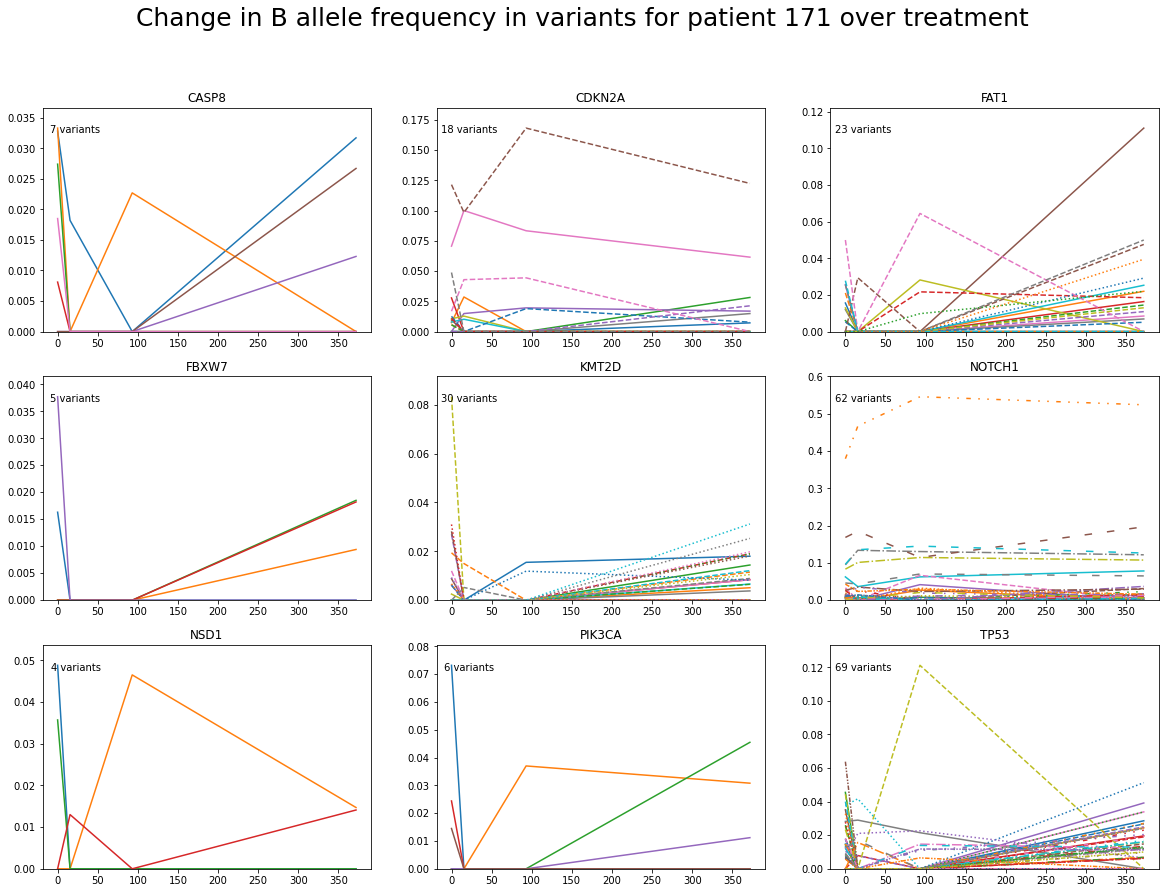

In [23]:
keydict = {}
for subject in subjects:
    keydict[subject] = {}
    x = [i*31 for i in xvals[:len(recc2[subject]['all'])]]
    fig, ax = plt.subplots(3,3, figsize = (20,14))
    ax = list(itertools.chain(*[i for i in ax]))
    idx = 0
    for gene in genes:
        keydict[subject][gene] = {}
        if len([BAF_dict[subject][gene][i] for i in BAF_dict[subject][gene]]) == 0:
            scaler = 1
        else:
            scaler = max([max(list(BAF_dict[subject][gene][i].values())) for i in BAF_dict[subject][gene]])
        nolegends = 0
        nolin = 0
        old_scale = 0
        ax1 = ax[idx]
        ax1.set_title(gene)
        for var in BAF_dict[subject][gene]:
            if nolin < 10:
                linestyle = '-'
            elif nolin >= 10 and nolin < 20:
                linestyle = '--'
            elif nolin >= 20 and nolin < 30:
                linestyle = ':'
            elif nolin >= 30 and nolin < 40:
                linestyle = '-.'
            elif nolin >= 40 and nolin < 50:
                linestyle = (0, (3, 5, 1, 5, 1, 5))
            elif nolin >= 50 and nolin < 60:
                linestyle = (0, (5, 10))
            elif nolin >= 60 and nolin < 70:
                linestyle = (0, (3, 1, 1, 1, 1, 1))
            elif nolin >= 70:
                linestyle = (0, (3, 10, 1, 10))
            ax1.set_ylim(0, scaler + (scaler*0.10))
            p = ax1.plot(x, list(BAF_dict[subject][gene][var].values()), label = var, linestyle = linestyle)
            keydict[subject][gene][var] = p[0]

            nolin += 1
        vars = len([BAF_dict[subject][gene][i] for i in BAF_dict[subject][gene]])
        ax1.text(0.1, 0.9,f'{vars} variants',
        horizontalalignment='center',
        verticalalignment='center',
        transform = ax1.transAxes)
        idx += 1
    fig.suptitle(f'Change in B allele frequency in variants for patient {subject} over treatment', size = 25)
    plt.savefig(f'outputs/recurrence_profiles/patient{subject}')
    plt.savefig(f'outputs/recurrence_profiles/patient{subject}.svg', format='svg')

In [24]:
for subject in keydict:
    for gene in keydict[subject]:
        keys = np.array(list(keydict[subject][gene].keys()))
        lines = np.array(list(keydict[subject][gene].values()))
        nolegends = np.ceil(len(keys) / 10)
        if nolegends == 0:
            continue
        indcs = np.array_split(np.array(list(range(len(keys)))), nolegends)
        for idx in indcs:
            a = lines[list(idx)]
            b = keys[list(idx)]
            legendFig = plt.figure("Legend plot")
            legendFig.legend(a, b, loc='center')
            legendFig.savefig(f'outputs/recurrence_profiles/legends/{subject}_{gene}_{int(nolegends)}')
            plt.clf()

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/recurrence_profiles/legends/110_CASP8_1.png'

<Figure size 432x288 with 0 Axes>